In [403]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [404]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import seaborn as sns
import sys

sys.path.append("/Users/lukevolpatti/Documents/thesis/signal-decomposition/")
from gfosd import Problem
from gfosd.components import *
from matplotlib import pyplot as plt
import qss

# Gaussian noise plus outliers

## Data generation

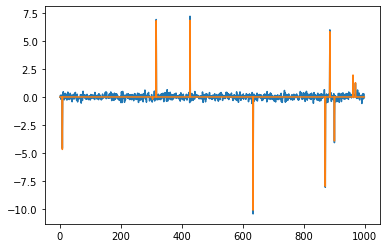

In [1337]:
T = int(1e3)
np.random.seed(42)
aa = T // 4
bb = T // 6
signal = 10 * np.random.randn(T)
indices = np.random.choice(np.arange(T), replace=False,
                           size=int(T * 0.99))
signal[indices] = 0
noise = 0.2 * np.random.randn(T)
y = signal + noise
X_real = np.asarray([noise, signal])

plt.figure()
plt.plot(y)
plt.plot(signal)
plt.show();

## Problem formulation

## l0 solution

In [1338]:
c1 = SumSquare(weight=1)
c2 = SumCard(weight=1)
problem = Problem(components=[c1, c2], data=y)

In [1339]:
problem.decompose(verbose=True, precond=True, adaptive_rho=True, alpha=1, max_iter=1000)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
preconditioning time:            2.44e-02s
initial factorization time:      4.71e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 4.41e+00    5.73e+00     9.99e-01   [0.1 0.1]  9.21e-04
   25 | 1.80e+01    6.32e+00     1.17e+00   [0.1 0.1]  2.43e-02
   50 | 2.68e+01    2.41e+00     3.72e+00   [5.71140484e-01 1.00000000e-06]  4.21e-02
   75 | 3.09e+01    2.17e+00     1.70e+00   [5.71140484e-01 1.00000000e-06]  5.32e-02
  100 | 2.84e+01    2.05e+00     1.70e+00   [5.71140484e-01 1.00000000e-06]  6.63e-02
  125 | 2.99e+0

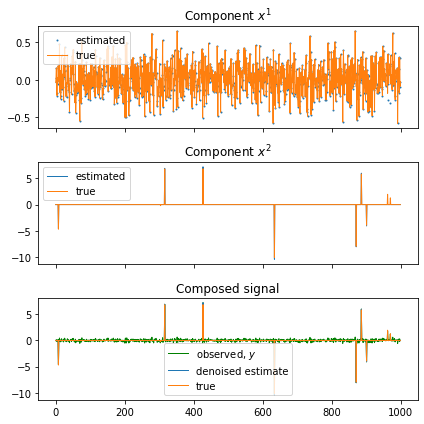

In [1340]:
problem.plot_decomposition(X_real=X_real, figsize=(6,6))
plt.show()

In [1341]:
gf = problem.make_graph_form()
gf["g"][0]["g"] = "card_constr"
gf["g"][0]["args"]["k"] = 10

In [1385]:
solver = qss.QSS(gf)
res, x_qss = solver.solve(verbose=True, precond=True, adaptive_rho=False, max_iter=200, alpha=1, random_init=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
preconditioning time:            9.97e-03s
initial factorization time:      3.38e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.31e+06    2.44e+02     3.76e+02   [0.1 0.1]  6.60e-04
   25 | 3.74e+02    1.84e+01     2.24e+00   [0.1 0.1]  1.52e-02
   50 | 1.20e+02    4.22e+00     5.08e-01   [0.1 0.1]  2.94e-02
   75 | 1.15e+02    4.14e+00     4.57e-01   [0.1 0.1]  4.19e-02
  100 | 1.19e+02    4.41e+00     5.08e-01   [0.1 0.1]  5.27e-02
  125 | 1.20e+02    4.44e+00     5.08e-01   [0.1 0.1]  6.55e-02
  150 | 1.20e+02 

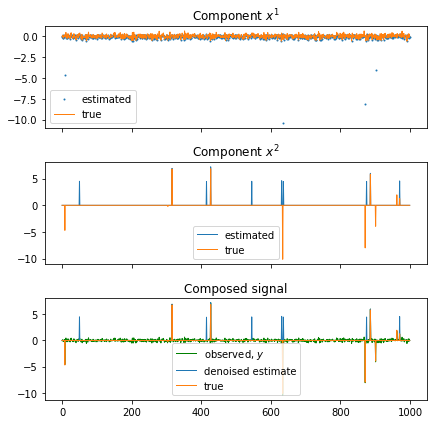

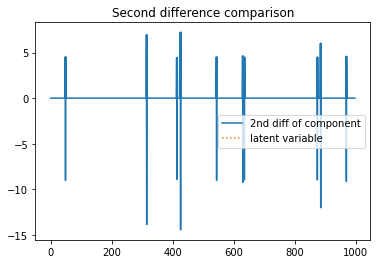

In [1386]:
problem.retrieve_result(x_qss)
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

## l1 solution

In [45]:
c1 = SumSquare(weight=1)
c2 = SumAbs(weight=0.5)
problem = Problem(components=[c1, c2], data=y)

In [46]:
problem.decompose(verbose=True, precond=False, adaptive_rho=True, max_iter=1000)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      4.60e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 4.12e+10    5.05e+04     3.16e+04   [0.1 0.1]  5.13e-04
   25 | 4.24e+01    8.82e-02     3.68e-03   [0.1 0.1]  9.77e-03
   50 | 4.53e+01    7.81e-04     6.62e-04   [1.12502124e+00 1.00000000e-06]  2.09e-02
   60 | 4.53e+01    6.16e-08     2.18e-08   [1.12502124e+00 1.00000000e-06]  2.51e-02
---------------------------------------------------------------
avg time per iter:               4.04e-04s
refactorizations:                1
to

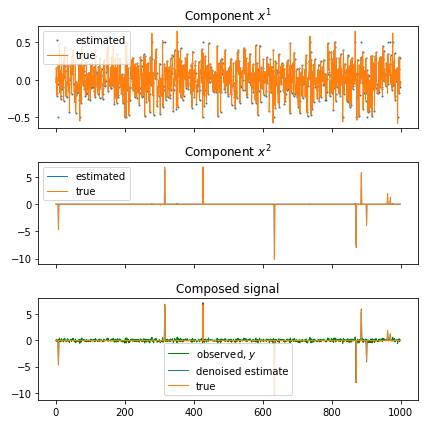

In [47]:
problem.plot_decomposition(X_real=X_real, figsize=(6,6))
plt.show()

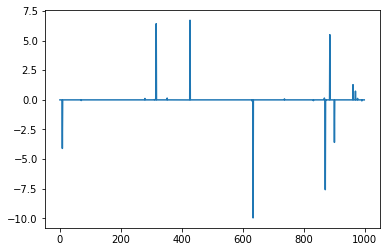

In [48]:
plt.plot(problem.decomposition[1])

# Section 2.9 nonconvex

## Data generation

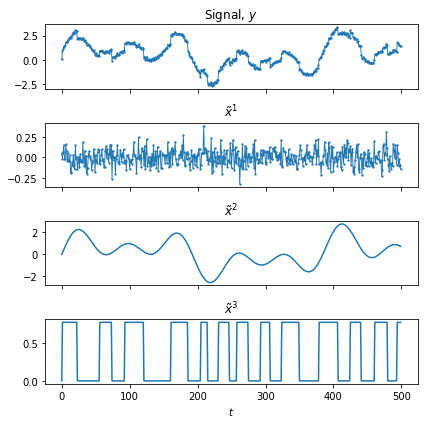

In [736]:
np.random.seed(42)

T = np.linspace(0, 1, 500)
scale = 0.7816 
rho = 0.75

x1_real = np.random.randn(len(T)) * 0.1

num_sines = 3
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=1, high=5, size=num_sines)
params = zip(frequencies, phases)
x2_real = np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)

num_sines = 7
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=30, high=32, size=num_sines)
params = zip(frequencies, phases)
x3_real = np.round(np.sign(np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)) / 2 + 0.5) * scale

X_real = np.array([x1_real, x2_real, x3_real])
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 6)) #(10, 8))
ax[0].plot(y, linewidth=0.9, marker='.', markersize=2.5)
ax[1].plot(x1_real, linewidth=0.9, marker='.', markersize=2.5)
ax[2].plot(x2_real)
ax[3].plot(x3_real)
ax[0].set_title('Signal, $y$')
for i in range(X_real.shape[0]):
    ax[i + 1].set_title('$\\tilde{x}^{'+'{}'.format(i + 1)+'}$')
ax[-1].set_xlabel('$t$')
plt.tight_layout()

## Problem formulation

In [737]:
c1 = SumSquare(weight=10/len(y))
c2 = SumSquare(weight=1, diff=2)
c3 = FiniteSet(values={0, scale}, weight=1)
components = [c1, c2, c3]
prob = Problem(y, components)

## Solutions

In [738]:
prob.decompose(verbose=True, precond=True, adaptive_rho=False, schedule_rho=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
preconditioning time:            1.08e-02s
initial factorization time:      3.78e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.35e+04    5.95e+02     3.14e+01   [0.01 0.01]  7.57e-04
   25 | 1.62e+00    3.24e+00     9.92e-03   [0.01 0.01]  1.47e-02
   50 | 1.05e-01    1.00e+00     7.82e-03   [0.01 0.01]  3.18e-02
   75 | 1.89e-02    7.38e-01     7.82e-03   [0.01 0.01]  4.50e-02
  100 | 1.46e-02    7.73e-01     7.82e-03   [0.01 0.01]  5.73e-02
---------------------------------------------------------------
avg tim

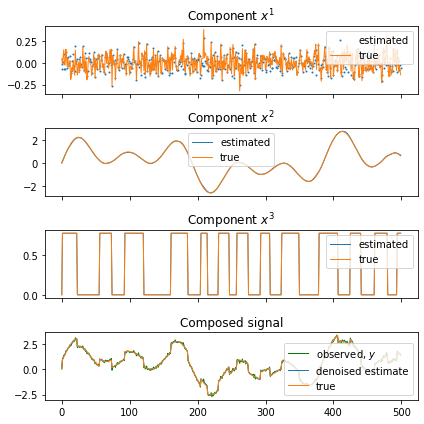

In [739]:
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.legend()

# l0 constant trend filtering

## Data generation

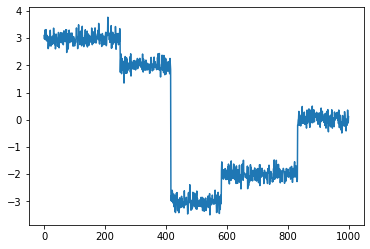

In [1022]:
T = int(1e3)
np.random.seed(42)
signal = np.ones(T)
aa = T // 4
bb = T // 6
signal[:aa] = 3
signal[aa:aa+bb] = 2
signal[aa+bb:aa+bb+bb] = -3
signal[aa+bb+bb:aa+bb+bb+aa] = -2
signal[aa+bb+bb+aa:] = 0
noise = 0.2 * np.random.randn(T)
y = signal + noise
X_real = np.asarray([noise, signal])

plt.plot(y)

## Problem formulation 

In [1030]:
c1 = SumSquare(weight=1)
c2 = SumCard(weight=10, diff=1)
problem = Problem(components=[c1, c2], data=y)

In [1031]:
problem.decompose(verbose=True, precond=False, adaptive_rho=False, schedule_rho=False, max_iter=1000, alpha=1)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      1.66e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.00e+01    3.63e+00     3.38e-01   [0.1 0.1]  1.48e-03
   25 | 2.68e+01    1.40e+01     1.67e+00   [0.1 0.1]  2.57e-02
   50 | 1.98e+01    6.60e+00     1.43e+00   [0.1 0.1]  3.98e-02
   75 | 1.87e+01    7.01e+00     1.69e+00   [0.1 0.1]  5.25e-02
  100 | 2.80e+01    1.09e+01     1.42e+00   [0.1 0.1]  6.98e-02
  125 | 1.80e+01    4.17e+00     1.23e-01   [0.1 0.1]  8.40e-02
  150 | 1.89e+01    6.65e+00     1.42e+00   [0.1 0.1]  9.78e

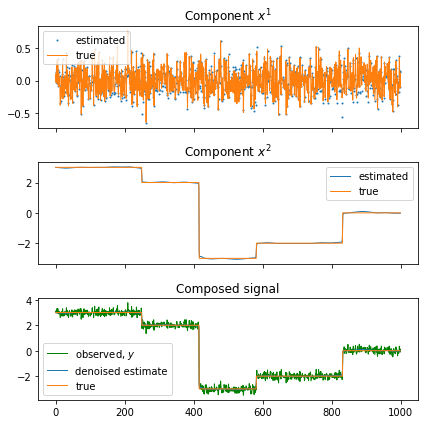

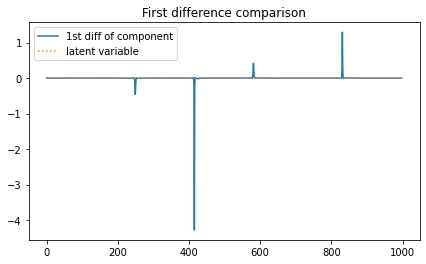

In [1032]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(np.diff(problem.decomposition[1], n=1), label="1st diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("First difference comparison")
plt.show()

# l0 trend filtering

## Data generation

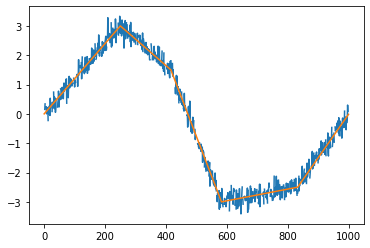

In [1404]:
T = int(1e3)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
]
noise = 0.2 * np.random.randn(T)
y = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.random.uniform(size=T) >= 0.2
y[~use_set] = np.nan

plt.figure()
plt.plot(y)
plt.plot(pwl)
plt.show();

## Problem formulation

In [1644]:
c1 = SumSquare(weight=1)
c2 = SumCard(weight=2000, diff=2)
problem = Problem(components=[c1, c2], data=y)
objective_values = {}

In [1645]:
problem.decompose(verbose=True, precond=False, adaptive_rho=False, max_iter=100, alpha=1, schedule_rho=True, random_init=False)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      1.55e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 4.24e+05    6.29e+02     3.67e+01   [0.01 0.01]  1.06e-03
   25 | 7.82e+04    9.65e+00     2.28e-02   [0.01 0.01]  2.14e-02
   50 | 7.81e+04    2.06e+00     9.08e-04   [0.01 0.01]  3.65e-02
   75 | 7.80e+04    1.34e+00     2.85e-04   [0.01 0.01]  5.12e-02
  100 | 7.80e+04    9.31e-01     1.64e-04   [0.01 0.01]  6.77e-02
---------------------------------------------------------------
avg time per iter:               6.82e-04s
refacto

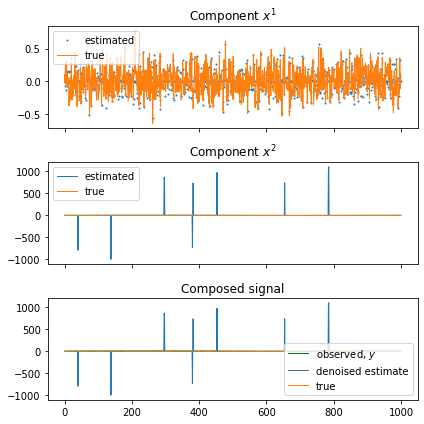

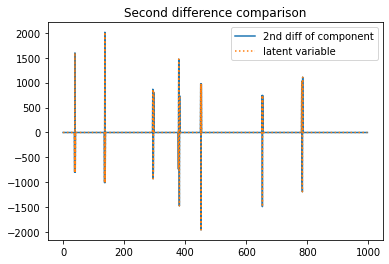

In [1646]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

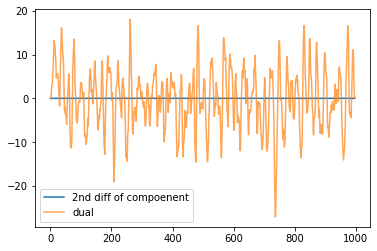

In [1639]:
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of compoenent")
plt.plot(problem.dual[-998:], label="dual", alpha=0.7)
plt.legend()

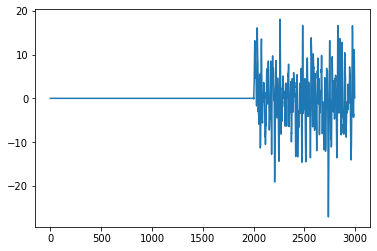

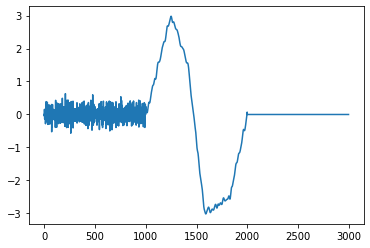

In [1640]:
plt.figure()
plt.plot(problem.dual)
plt.show()

plt.figure()
plt.plot(problem._qss_soln)
plt.show()

## Experimenting with other penalties

In [1327]:
gf = problem.make_graph_form()

In [1328]:
gf

{'P': <2998x2998 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1796x2998 sparse matrix of type '<class 'numpy.float64'>'
 	with 5588 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., -0.13062482,
         0.3000135 ,  0.08352572]),
 'g': [{'g': 'card', 'args': {'weight': 1000}, 'range': (2000, 2998)}]}

In [1329]:
gf["g"][0]["g"] = "card_constr"
gf["g"][0]["args"]["k"] = 4

In [1330]:
solver = qss.QSS(gf)

In [1335]:
rho_list = np.concatenate([10 * np.random.rand(9), np.zeros(1)])

In [ ]:
# best_res = np.inf
# best_params = None
# best_x_qss = 0

# c1_weights = np.logspace[-5

# for c1_weight in np.logspace(-5, 5)
# for rho in rho_list:
#     for precond in [True, False]:
#         for adaptive_rho in [True, False]:
#             for random_init in [True, False]

In [1332]:
best_res = np.inf
best_x_qss = 0
for rho in rho_list:
    res, x_qss = solver.solve(verbose=False, precond=False, adaptive_rho=False, max_iter=1000, alpha=1, random_init=False, rho=rho)
    if res < best_res:
        best_res = res
        best_x_qss = x_qss
best_res

0.11703506768052999

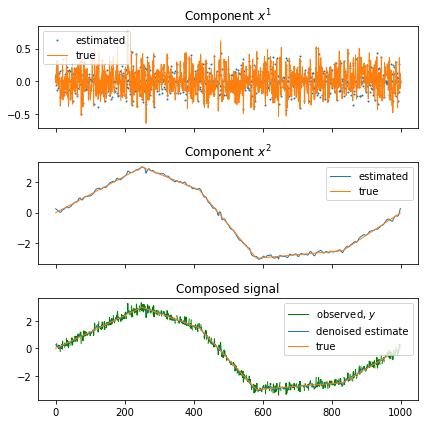

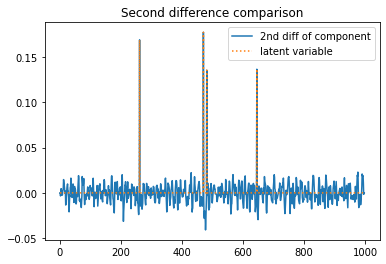

In [1333]:
problem.retrieve_result(best_x_qss)
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(best_x_qss[T:2*T], n=2), label="2nd diff of component")
plt.plot(best_x_qss[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()